Limits Generator

In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits
from utilities_widgets import position_chart, widget_selector, widget_int_entry
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
means_calculation = widget_selector(options=['Global means', 'Per position means'], description='Means algorithm', tooltips=['Calculate global means for each limit', 'Calculate means for each position'])
auto_position = widgets.Checkbox(value=False, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
try: #Tries to find a table for the fixture data
    fixture_data = consult_database("input.db", verbose=False, filter="_FixtureData_")[-1]
    file = '_'.join(fixture_data.split("_")[:-7])
except: #Resorts to using globals values
    file = re.sub(r'\W', '_', glob.tooling)
try: #Tries to search for the last tables related to the fixture data
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[-1]
except Exception as e:
    raise Exception("Missing the required tables. Ensure you have the required tables.")
try: #Tries to find a table for the fixture data to compose
    value=(default_measurements, default_limits, fixture_data)
except:
    value=(default_measurements, default_limits)
tables = widgets.SelectMultiple(options=table_list, value=value, description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "FixtureData" in string), None), index_col="index")
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('TOP_PASSAT_B9_…

Table *TOP_PASSAT_B9_Measurements_2024y_08m_09d_11h_42m_40s* retrieved succesfully.
Table *TOP_PASSAT_B9_Limits_2024y_08m_09d_11h_42m_40s* retrieved succesfully.
Table *TOP_PASSAT_B9_FixtureData_2024y_08m_09d_13h_14m_06s* retrieved succesfully.


In [4]:
##Mean dataframe creation
display(means_calculation)
if means_calculation.value == 'Global means':
    means_df = mean_calculator(MEAS) #Global means version
elif means_calculation.value == 'Per position means':
    means_df = mean_calculator(MEAS, glob.lenses_per_nest) #Per position means version
means_df_format = rename_index(means_df)
means_df_format

ToggleButtons(description='Means algorithm', options=('Global means', 'Per position means'), tooltips=('Calcul…

,mean
Guia_Luz_Blanco_FB1_X,0.340903
Guia_Luz_Blanco_FB1_Y,0.361896
Guia_Luz_Blanco_FB2_X,0.340903
Guia_Luz_Blanco_FB2_Y,0.361896
Guia_Luz_Blanco_FB3_X,0.340903
Guia_Luz_Blanco_FB3_Y,0.361896
Guia_Luz_Blanco_FB4_X,0.340903
Guia_Luz_Blanco_FB4_Y,0.361896
Guia_Luz_Blanco_FB5_X,0.340903
Guia_Luz_Blanco_FB5_Y,0.361896


In [5]:
##Rearanged limits dataframe calculation
new_limits = limits_generator(means_df)
limits_format = rename_index(new_limits)
print("Adjusted limits")
limits_format

Adjusted limits


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.328403,0.353403
Guia_Luz_Blanco_FB1_Y,0.345396,0.378396
Guia_Luz_Blanco_FB2_X,0.328403,0.353403
Guia_Luz_Blanco_FB2_Y,0.345396,0.378396
Guia_Luz_Blanco_FB3_X,0.328403,0.353403
Guia_Luz_Blanco_FB3_Y,0.345396,0.378396
Guia_Luz_Blanco_FB4_X,0.328403,0.353403
Guia_Luz_Blanco_FB4_Y,0.345396,0.378396
Guia_Luz_Blanco_FB5_X,0.328403,0.353403
Guia_Luz_Blanco_FB5_Y,0.345396,0.378396


In [6]:
##Data review
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
output = pd.concat([MEAS_format, limits_format], axis=1) #Concatenates the measures and limits
output

,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 23,test: 24,test: 25,test: 26,test: 27,test: 28,test: 29,test: 30,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.3511,0.3487,0.3505,0.3546,0.3360,0.3253,0.3265,0.3566,0.3550,0.3542,...,0.3548,0.3575,0.3245,0.3588,0.3592,0.3540,0.3538,0.3579,0.328403,0.353403
Guia_Luz_Blanco_FB1_Y,0.3619,0.3612,0.3617,0.3625,0.3572,0.3546,0.3550,0.3625,0.3625,0.3630,...,0.3629,0.3636,0.3540,0.3637,0.3642,0.3625,0.3625,0.3635,0.345396,0.378396
Guia_Luz_Blanco_FB2_X,0.3333,0.3482,0.3326,0.3349,0.3328,0.3298,0.3320,0.3352,0.3351,0.3375,...,0.3357,0.3359,0.3296,0.3366,0.3364,0.3350,0.3352,0.3363,0.328403,0.353403
Guia_Luz_Blanco_FB2_Y,0.3566,0.3579,0.3565,0.3578,0.3570,0.3566,0.3580,0.3575,0.3578,0.3601,...,0.3581,0.3591,0.3564,0.3589,0.3589,0.3580,0.3579,0.3590,0.345396,0.378396
Guia_Luz_Blanco_FB3_X,0.3430,0.3442,0.3442,0.3423,0.3422,0.3434,0.3425,0.3419,0.3417,0.3457,...,0.3424,0.3419,0.3417,0.3423,0.3425,0.3441,0.3436,0.3422,0.328403,0.353403
Guia_Luz_Blanco_FB3_Y,0.3695,0.3697,0.3699,0.3686,0.3686,0.3695,0.3684,0.3678,0.3684,0.3715,...,0.3684,0.3683,0.3684,0.3687,0.3684,0.3697,0.3696,0.3686,0.345396,0.378396
Guia_Luz_Blanco_FB4_X,0.3537,0.3548,0.3551,0.3505,0.3379,0.3275,0.3277,0.3509,0.3512,0.3512,...,0.3568,0.3540,0.3258,0.3541,0.3546,0.3568,0.3546,0.3578,0.328403,0.353403
Guia_Luz_Blanco_FB4_Y,0.3601,0.3600,0.3600,0.3596,0.3564,0.3552,0.3553,0.3595,0.3595,0.3596,...,0.3605,0.3599,0.3541,0.3599,0.3600,0.3604,0.3600,0.3603,0.345396,0.378396
Guia_Luz_Blanco_FB5_X,0.3348,0.3349,0.3348,0.3342,0.3337,0.3325,0.3310,0.3350,0.3346,0.3353,...,0.3361,0.3359,0.3315,0.3362,0.3365,0.3364,0.3352,0.3369,0.328403,0.353403
Guia_Luz_Blanco_FB5_Y,0.3594,0.3590,0.3589,0.3587,0.3598,0.3597,0.3587,0.3591,0.3587,0.3591,...,0.3600,0.3598,0.3588,0.3598,0.3599,0.3602,0.3600,0.3595,0.345396,0.378396


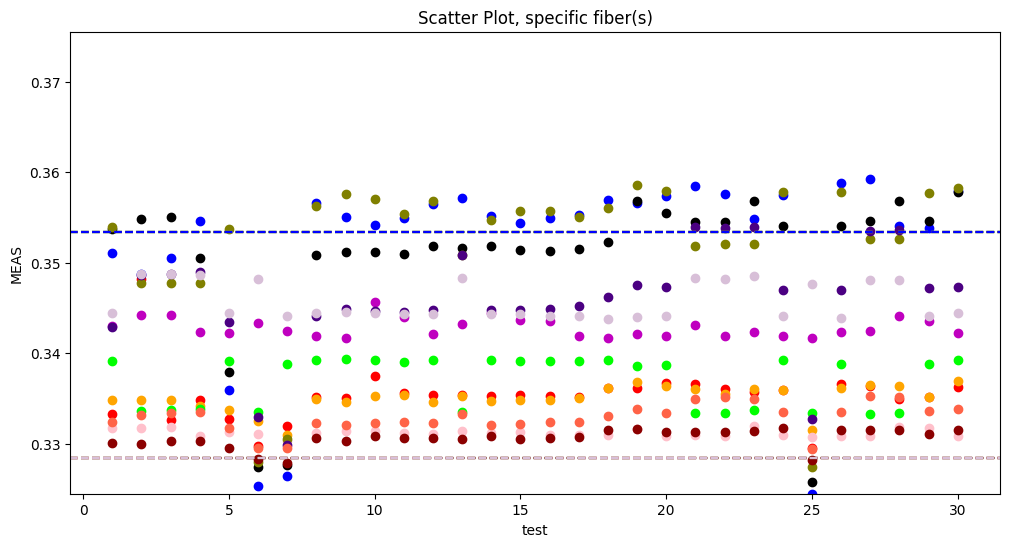

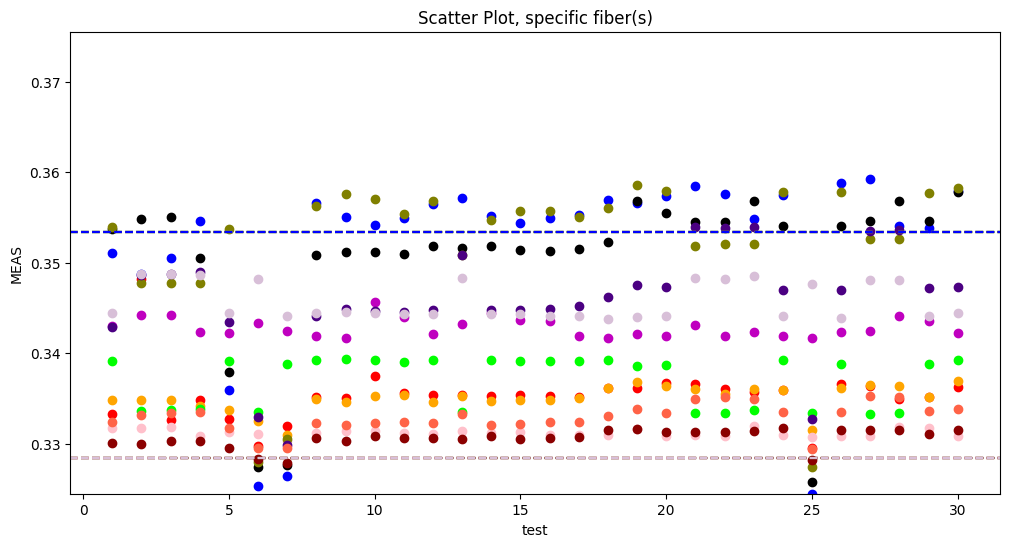

In [8]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([auto_position, mean_slider, range_slider]))
plot_scatter(MEAS, title='Scatter Plot, specific fiber(s)', xlabel='test', ylabel='MEAS', limits=new_limits, filter=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], yrange=yrange)

In [10]:
##Data export and limit file generation
name = glob.tooling + "_" + get_date() + ".xlsx"
confirmation = input("Do you want to export the data to a new Target.xlsx file and generate a new limits ini file? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.join(os.path.abspath("../a2_output"), name)
    output.to_excel(output_filepath, index=True, header=True)
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    ini_generator(new_limits, glob.lenses_per_nest, glob.nests_number)
    print(f'Data exported inside: {output_filepath}')
    print(f'Limits generated at: {os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

[LIMITS_GENERIC]
Guia_Luz_Blanco_FB1_X_MAX = 0.3403
Guia_Luz_Blanco_FB1_X_MIN = 0.3153
Guia_Luz_Blanco_FB1_Y_MAX = 0.3664
Guia_Luz_Blanco_FB1_Y_MIN = 0.3334
Guia_Luz_Blanco_FB2_X_MAX = 0.3403
...
Data exported inside: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output\VA-007_2024y-01m-10d_8h-12m-45s.xlsx
Limits generated at: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output


In [ ]:
##Update of the database
name = re.sub(r'\W', '_', glob.tooling + "_" + get_date()) + "_limits&corrected"
confirmation = input("Do you want to export the new limits to your database (y/n): ").strip().lower()
if confirmation == 'y':
    prepare_database("input.db", new_limits, name) #Store a df for the limits inside the database of the project
    limits_file = rename_limits_table("output.db", name)
    print("Limit files renamed for clarity.")
    consult_database("input.db", verbose=True)
else:
    print("Operation canceled.")

Operation canceled.
